In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.0.0'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, gzip
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

## Exercise 1

Load MNIST and train an RBM. Remember to **normalize** pixel luminosities to the [0-1] interval.

In [4]:

mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
numbers_X = mnist[:,1:785]/255.
numbers_y = mnist[:,0]


print (numbers_X.shape, numbers_X.shape)

(1500, 784) (1500, 784)


the following code counts the numbers of instances for each digit and a sample of the dataset.

In [6]:
print ("TRAIN numbers class distribution")
pd.DataFrame(pd.Series(numbers_y).value_counts()).T


TRAIN numbers class distribution


,2,1,7,6,4,0,9,8,5,3
0,186,157,154,152,151,150,146,141,138,125


In [7]:
def show_linearized_images_sample(X, n_images=200, permutation=True):
    plt.figure(figsize=(18,8))
    Xp = np.random.permutation(X) if permutation else X
    img =  np.rollaxis(np.rollaxis(Xp[:n_images].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.axis("off")

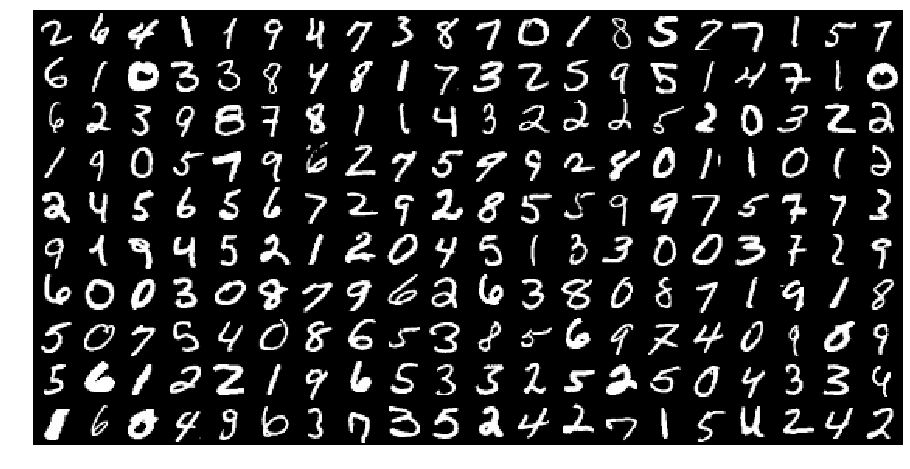

In [8]:
show_linearized_images_sample(numbers_X)


create and train an RBM with 100 components, batch_size 5, learning_rate 0.1 and 100 iterations with `numbers_X`

In [9]:
dim_H = 100

from sklearn.neural_network import BernoulliRBM

rbm = BernoulliRBM(n_components=dim_H, batch_size=5, learning_rate=.1, n_iter=100, random_state=None, verbose=1)
rbm.fit(numbers_X);
c, b, W = rbm.intercept_visible_, rbm.intercept_hidden_, rbm.components_

[BernoulliRBM] Iteration 1, pseudo-likelihood = -159.24, time = 0.20s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -127.83, time = 0.22s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -131.22, time = 0.21s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -116.84, time = 0.21s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -111.08, time = 0.21s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -118.41, time = 0.23s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -127.60, time = 0.21s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -94.90, time = 0.21s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -123.30, time = 0.21s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -105.10, time = 0.21s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -112.32, time = 0.20s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -111.20, time = 0.25s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -114.20, time = 0.23s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -108.64, time = 0.21s
[BernoulliRBM] I

### plot the 100 components from the trained RBM (matrix `W`)

you should see something approximately like this


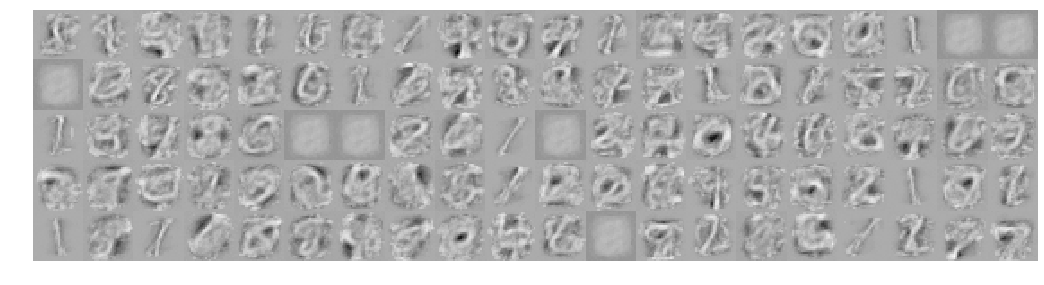

In [10]:
show_linearized_images_sample(W, n_images=len(W))

## Exercise 2

- Load into `fashion_X` 1500 fashion MNIST images and do not forget to normalize their luminosity to the  [0-1] interval.
- Create 1500 random noise images into a variable named `random_imgs` (use `np.random.random(size=(1500,784))`) and set to zero any value under 0.7
- Use the previously trained RBM to compute the free energy of all elements in `fashion_X`, `number_X` , `number_X_sel` and `random_imgs`.
- Plot the histograms. You should see a clear separation of the four datasets.

Your histogram should look roughly like this

![alt text](./Images/lab_rbm_histograms.png)



In [11]:
def load_fashion_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

from tensorflow.keras import datasets
(fashion_X, fashion_y), (x_test, y_test) = datasets.fashion_mnist.load_data()
fashion_X = (fashion_X[:1500]/255.).reshape(-1,784)
np.min(fashion_X), np.max(fashion_X), np.sum(fashion_X)

(0.0, 1.0, 332487.07843137276)

In [12]:
fashion_X.shape

(1500, 784)

<Figure size 720x1440 with 0 Axes>

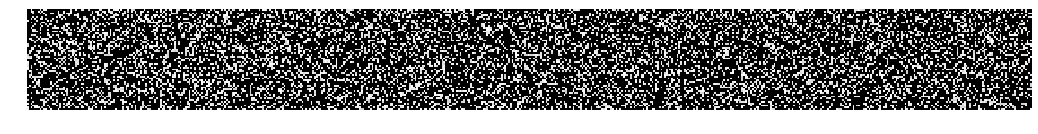

In [13]:
random_imgs = np.random.random(size=(1000,784))
random_imgs[random_imgs<.7]=0
plt.figure(figsize=(10,20))
show_linearized_images_sample(random_imgs, n_images=40)

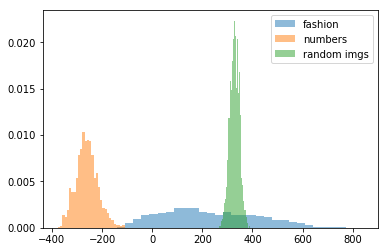

In [14]:
def free_energy(v,c,b,W):
    v = v.reshape(-1, v.shape[-1])
    return - v.dot(c)- np.logaddexp(0, v.dot(W.T) + b).sum(axis=1) 

plt.hist(free_energy(fashion_X, c, b, W), bins=30, label="fashion", alpha=.5, density=True);
plt.hist(free_energy(numbers_X, c, b, W), bins=30, label="numbers", alpha=.5, density=True);
plt.hist(free_energy(random_imgs, c, b, W), bins=30, label="random imgs", alpha=.5, density=True);
plt.legend();

## Exercise 3: 

Select a random set of 40 digits and perform a 100 steps Gibbs sampling for each one of them. 

Follow the example here: https://www.kaggle.com/nicw102168/restricted-boltzmann-machine-rbm-on-mnist

Your generation might look like:

![alt text](./Images/lab_rbm_generated.png)




<Figure size 720x1440 with 0 Axes>

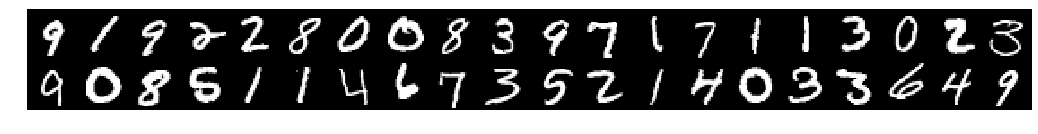

In [15]:
xx = random_imgs[:60].copy()
xx = numbers_X[:40].copy()
plt.figure(figsize=(10,20))
show_linearized_images_sample(xx)

In [16]:
for ii in range(100):
    for n in range(len(xx)):
        xx[n] = rbm.gibbs(xx[n])

<Figure size 720x1440 with 0 Axes>

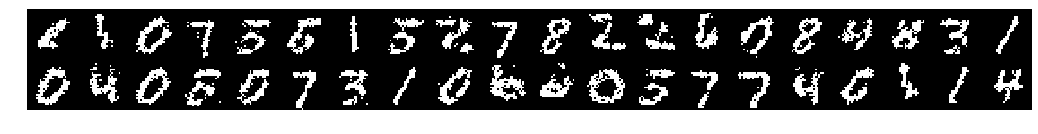

In [17]:
plt.figure(figsize=(10,20))
show_linearized_images_sample(xx, len(xx), permutation=False)

## Exercise 4

Select a simple sklearn classification method (such as GaussianNB or LogisticRegression), make a random train/test split of 50% on MNIST digits and then:

- train and measure the performance of your selected method directly with the raw MNIST data
- train and measure the perofrmance of your selected method **after** transforming MNIST data with the previously trained RBM

you should see some improvement after transforming the data.

In [18]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(numbers_X, numbers_y, train_size=.5)

In [19]:
from sklearn.naive_bayes import GaussianNB

gb = GaussianNB()
gb.fit(Xtr, ytr)
gb.score(Xtr, ytr), gb.score(Xts, yts)

(0.7533333333333333, 0.5906666666666667)

In [20]:
gb.fit(rbm.transform(Xtr), ytr)
gb.score(rbm.transform(Xtr), ytr), gb.score(rbm.transform(Xts), yts)

(0.844, 0.7853333333333333)